# Quick Analysis 

Notebook to perform quick analysis and visualization to debug the simulation.

In [1]:
%matplotlib inline

import os
import sys 

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.dynamo import *

{1: 0.7254509018036072, 2: 0.24649298597194388, 3: 0.028056112224448898}


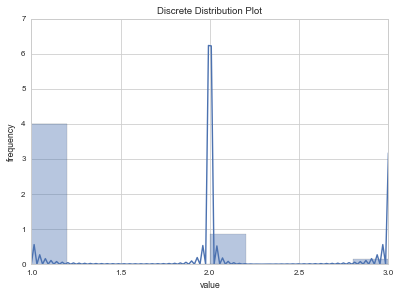

In [7]:
d = DiscreteDistribution([1,2,3], [362, 123, 14])
print d.probabilities
d.plot(random_seed=20, n=100)